In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tables
from icecube import astro, dataio, paraboloid
import pandas as pd
import glob, os, json
from icecube.weighting import fluxes
from icecube import NewNuFlux, dataclasses
import simweights

# Combine Corsika Files

In [3]:
def read_json(path):
    lookup = {}
    processing_json = json.load(open(path, 'r'))['tasks']
    
    for task in processing_json:
        lookup[task['output']] = len(task['input'])
        
    return lookup
    

def count_files(run):
    # Count the actual number of input level2 files correspond
    # to the set of files processed in a given level3 directory.
    # To do this properly, we read the json file used for running
    # the level3, which will tell us the exact number of level2 
    # files corresponding to each level3 file.
    
    #json_processing_path = "/cvmfs/icecube.opensciencegrid.org/users/NeutrinoSources/iceprod2/muon_level3/"
    json_processing_path = "/home/mlarson/dag_for_osg/muon_level3/"
    json_file = os.path.join(json_processing_path,
                             f"muon_level3_{run}.json")
    input_per_output = read_json(json_file)

    # And grab the list of level3 processed files
    level3_dir = f"/data/ana/PointSource/muon_level3/sim/IC86.*/{run}/"
    level3_path = os.path.join(level3_dir, "*")
    level3_files = glob.glob(level3_path)
    
    # Start counting
    nfiles = 0
    for f in level3_files:
        if not f in input_per_output.keys(): 
            print(f"Found file {f} which is not supposed to exist!")
            continue
        nfiles += input_per_output[f]
    print(f"Run {run} has {nfiles} processed.")
    return nfiles

In [4]:
LE_file = tables.File("/data/ana/PointSource/Galactic_Center/i3_processing/L5/sim/IC86_2016/Corsika/20881/Level5_IC86.2016_corsika.020881.hdf5", "r")
LE_weighter = simweights.CorsikaWeighter(LE_file, nfiles = count_files(20881))

ME_file = tables.File("/data/ana/PointSource/Galactic_Center/i3_processing/L5/sim/IC86_2016/Corsika/21120/Level5_IC86.2016_corsika.020789.hdf5", "r")
ME_weighter = simweights.CorsikaWeighter(ME_file, nfiles = 32093)

HE_file = tables.File("/data/ana/PointSource/Galactic_Center/i3_processing/L5/sim/IC86_2016/Corsika/21121/Level5_IC86.2016_corsika.020848.hdf5", "r")
HE_weighter = simweights.CorsikaWeighter(HE_file, nfiles = 912)


Run 20881 has 94470 processed.


In [5]:
Corsika_score1 = np.concatenate((HE_file.root.BDT_score.cols.value[:], ME_file.root.BDT_score.cols.value[:], LE_file.root.BDT_score.cols.value[:]))
Corsika_score2 = np.concatenate((HE_file.root.BDT2_score.cols.value[:], ME_file.root.BDT2_score.cols.value[:], LE_file.root.BDT2_score.cols.value[:]))

Corsika_dec = np.concatenate((HE_file.root.SplineMPE.cols.zenith[:]-np.pi/2, ME_file.root.SplineMPE.cols.zenith[:]-np.pi/2, LE_file.root.SplineMPE.cols.zenith[:]-np.pi/2))


In [6]:
combined_weighter = HE_weighter + ME_weighter + LE_weighter


In [7]:
# create a flux object and calculate the weights for all three weighters
flux_model = simweights.GaisserH3a()
HE_weights = HE_weighter.get_weights(flux_model)
ME_weights = ME_weighter.get_weights(flux_model)
LE_weights = LE_weighter.get_weights(flux_model)
combined_weights = combined_weighter.get_weights(flux_model)


In [8]:
# use Weighter.get_weight_column() to get the MC truth energy for each sample
HE_energy = HE_weighter.get_weight_column("energy")
ME_energy = ME_weighter.get_weight_column("energy")
LE_energy = LE_weighter.get_weight_column("energy")
combined_true_energy = combined_weighter.get_weight_column("energy")


combined_energy = np.concatenate((HE_file.root.SplineMPEMuEXDifferential.cols.energy[:], ME_file.root.SplineMPEMuEXDifferential.cols.energy[:], LE_file.root.SplineMPEMuEXDifferential.cols.energy[:]))

In [9]:
Nugen = np.load('/data/ana/PointSource/Galactic_Center/version-001-p00/IC86_2016_20878_L5_MC.npy')
Data = np.load('/data/ana/PointSource/Galactic_Center/version-001-p00/IC86_2016_L5_data.npy')

In [10]:
# weight nugen astro
data_run = Data['run']
data_time = Data['time']
LT_days = 0
for run in np.unique(data_run):
    mask = (data_run == run)
    min_time = np.min(data_time[mask])
    max_time = np.max(data_time[mask])
    run_time = max_time - min_time
    #print(run_time)
    LT_days += run_time
LT = LT_days*86400
print(LT_days)

nugen_oneweight = Nugen['ow']


nugen_trueE = Nugen['trueE']

gamma = 2.7
fluxNorm = 1.0e-18
nugen_weights_astro = fluxNorm * nugen_oneweight * (nugen_trueE/1.0e5)**(-gamma) * LT

# weight nugen atmo
flux = NewNuFlux.makeFlux ('honda2006')
flux.knee_reweighting_model = 'gaisserH3a_elbert'
flux.relative_kaon_contribution = 1.0

Nugen_trueE = Nugen['trueE']
Nugen_true_Dec = Nugen['trueDec']

weight_atmo_honda2006  = flux.getFlux(dataclasses.I3Particle.NuMu, Nugen_trueE, -np.sin(Nugen_true_Dec))
nugen_weights_atmo =  2* nugen_oneweight * weight_atmo_honda2006 * LT

360.5774499442268


In [14]:
nugen_weights = nugen_weights_astro + nugen_weights_atmo
corsika_weights = combined_weights

In [21]:
def plot_mc_data_hist(a,b, nugen, corsika, data, title, xlabel, nbins, xmin = None, xmax = None):
    
    mc_hist = [nugen, corsika]
    mc_weight = [nugen_weights/LT, corsika_weights]
    h_mc = a.hist(mc_hist, weights=mc_weight, histtype='step', stacked=True, fill=True,bins = nbins, 
             label = ['Nugen', 'Corsika'],color = ['salmon', 'skyblue']
                 )
    h_data = a.hist(data, bins = h_mc[1], histtype = 'step', label = 'Data', 
            weights = np.ones(len(Data['logE']))/LT);
    h_mc_check = a.hist(np.concatenate((nugen, corsika)), bins = h_mc[1], histtype = 'step', label = 'MC',
                       weights = np.concatenate((nugen_weights/LT, corsika_weights)))
    a.grid()
    a.set_yscale('log')
    a.set_title(str(title))
    a.set_ylabel('Event Rate')
    a.set_xlim(xmin, xmax)
        
    b.plot(h_mc[1][1:], h_data[0]/h_mc[0][1])
    #b.set_yscale('log')
    
    b.set_ylabel('Ratio (Data/MC)')
    b.set_xlabel(str(xlabel))
    #b.locator_params(axis='y',tight=True, nbins=2)
    b.grid()
    b.set_xlim(xmin, xmax)


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


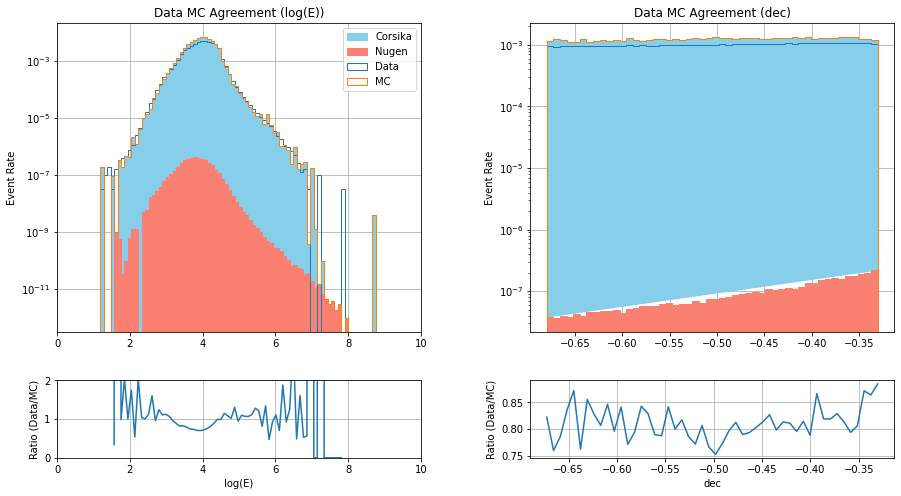

In [22]:

f, (a0, a1) = plt.subplots(2, 2, gridspec_kw={'height_ratios': [4, 1]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.25, wspace = 0.3)

plot_mc_data_hist(a0[0],a1[0], Nugen['logE'], np.log10(combined_energy), Data['logE'], 'Data MC Agreement (log(E))', 'log(E)', 
                 nbins = 80, xmin = 0, xmax = 10)
a0[0].legend()
#a1[0].set_yscale('log')
a1[0].set_ylim(0,2)


plot_mc_data_hist(a0[1],a1[1], Nugen['dec'], Corsika_dec, Data['dec'], 'Data MC Agreement (dec)', 'dec', nbins = 50)
